In [ ]:
#hide
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
 
import json
 
api_token = {"username":"nitinkashyap","key":"b0a54ce5183e803af6428bfa11d5c539"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c tabular-playground-series-jun-2021

  0% 0.00/3.14M [00:00<?, ?B/s]
100% 3.14M/3.14M [00:00<00:00, 106MB/s]
 77% 5.00M/6.49M [00:00<00:00, 43.3MB/s]
100% 6.49M/6.49M [00:00<00:00, 41.5MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 81.9MB/s]


In [ ]:
from sklearn.model_selection import StratifiedKFold

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import numpy as np
import seaborn as sns

In [ ]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip') 
sample_submission = pd.read_csv('sample_submission.csv.zip')

train.target = pd.Categorical(train.target)
train['target'] = train.target.cat.codes

indep_vars = ['feature_' + str(i) for i in range(75)]
dep_var = ['target']

In [ ]:

!pip install optuna
!pip install catboost

!pip install shap

from catboost import Pool, CatBoostClassifier

import catboost
import optuna
import shap

     |████████████████████████████████| 307kB 7.3MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 174kB 21.2MB/s 
     |████████████████████████████████| 143kB 25.9MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 112kB 27.4MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=25736bd654d36a09e93fd30cb6c095cfb875f32371c32cd94952e9f6e71de56e
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip
     |████████████████████████████████| 69.2MB 38kB/s 
     |████████████████████████████████| 358kB 8.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=8a08a0f333a477e798fadfceb652d10f8a38b8849b9354c5125b5ed004b99867
  Stored in directory: /root/.cache/pip/wheels/15/27

In [ ]:
train.shape, test.shape

((200000, 77), (100000, 76))

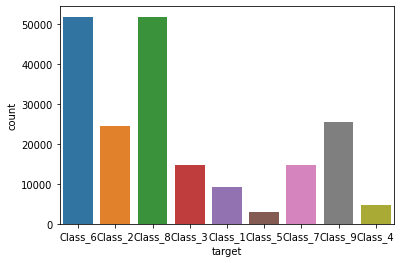

In [ ]:
sns.countplot(x='target', data=train)

In [ ]:
def train_models(df, columns, cat_features, random_state, n_splits):

    models = []
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True,
                            random_state=random_state)  # create folds
    X_train = df[columns]
    y_train = df['target']
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,  y_train)):
        print('Fold {}/{}'.format(n_fold, n_splits))
        train_X, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_X, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        dataset = Pool(train_X, train_y, cat_features)
        evalset = Pool(valid_X, valid_y, cat_features)
        model = CatBoostClassifier(
            task_type="GPU",
            depth=4,
            max_ctr_complexity=15,
            # border_count=1024,
            iterations=50000,
            od_wait=1000, od_type='Iter',
            # l2_leaf_reg=0.01,
            learning_rate=0.01,
            min_data_in_leaf=1,
            use_best_model=True,
            loss_function='MultiClass'

        )
        model.fit(dataset, plot=False, verbose=500, eval_set=evalset)        
        _record = {
            'model': model,
        }
        models.append(_record)

    return models

In [ ]:
train.shape[0]/10

20000.0

In [ ]:
models = train_models(df=train, columns=indep_vars, cat_features=indep_vars, random_state=43, n_splits=20)

In [ ]:
train.groupby('target').count()['id']*100/train.shape[0]

target
Class_1     4.5590
Class_2    12.2155
Class_3     7.3990
Class_4     2.3520
Class_5     1.5320
Class_6    25.9055
Class_7     7.3845
Class_8    25.8815
Class_9    12.7710
Name: id, dtype: float64

In [ ]:
X_test = test[indep_vars]

In [ ]:
def submissionFile(modelZ, generate_csv=True):   
    probabilities = pd.DataFrame(modelZ.predict_proba(X_test), columns=['Class_1','Class_2','Class_3','Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'])
    mySubmission = pd.DataFrame()
    mySubmission['id'] = test['id']
    mySubmission['Class_1'] = probabilities['Class_1']
    mySubmission['Class_2'] = probabilities['Class_2']
    mySubmission['Class_3'] = probabilities['Class_3']
    mySubmission['Class_4'] = probabilities['Class_4']
    mySubmission['Class_5'] = probabilities['Class_5']
    mySubmission['Class_6'] = probabilities['Class_6']
    mySubmission['Class_7'] = probabilities['Class_7']
    mySubmission['Class_8'] = probabilities['Class_8']
    mySubmission['Class_9'] = probabilities['Class_9']
    
    if generate_csv:
        mySubmission.to_csv('submission.csv', index=False)
    return mySubmission

In [ ]:
#models[2]['model'].predict_proba(X_train)
submissionFile(models[3]['model'])
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f submission.csv -m "Sample-May-Pipeline"

100% 17.9M/17.9M [00:00<00:00, 36.3MB/s]
Successfully submitted to Tabular Playground Series - Jun 2021

### Hyper parameter tuning using Optuna

In [ ]:
train.columns

Index(['id', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54',
       'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59',
       'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64',
   

In [ ]:
#X=train.drop(['target','id'],axis=1)
X = train
#Y=train['target']
Y = y

In [ ]:
def objective(trial,data=X,target=Y):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 7000, 25000),
            'od_wait':trial.suggest_int('od_wait', 1500, 3000),
            'loss_function':'MultiClass',
            'task_type':"GPU",
            'eval_metric':'MultiClass',
            'leaf_estimation_method':'Newton',
            'bootstrap_type': 'Bernoulli',
            'learning_rate' : trial.suggest_uniform('learning_rate',0.001,0.1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',50,100),
            'subsample': trial.suggest_uniform('subsample',0,1),
            'random_strength': trial.suggest_uniform('random_strength',18,30),
            'depth': trial.suggest_int('depth',3,6),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',10,30),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',2,6),
                }
    model = CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)], early_stopping_rounds=150, verbose=False)
        
    y_preds = model.predict_proba(X_test)


    log_loss_multi = log_loss(y_test, y_preds)
    
    return log_loss_multi

In [ ]:
OPTUNA_OPTIMIZATION = True


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-06-24 11:31:52,715] A new study created in memory with name: no-name-51ea7dd7-c8d2-4705-942e-90c8d8c2297b
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2021-06-24 11:32:06,212] Trial 0 finished with value: 1.7475517290197657 and parameters: {'iterations': 22081, 'od_wait': 2890, 'learning_rate': 0.0523585535392492, 'reg_lambda': 53.30046637750339, 'subsample': 0.8322426285324465, 'random_strength': 25.383248292425595, 'depth': 3, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 4}. Best is trial 0 with value: 1.7475517290197657.
[I 2021-06-24 11:32:32,838] Trial 1 finished with value: 1.746530009869069 and parameters: {'iterations': 16107, 'od_wait': 1934, 'learning_rate': 0.020694951401143857, 'reg_lambda': 76.40295318744504, 'subsample': 0.5779226659582111, 'random_strength': 18.674100622696255, 'depth': 4, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 3}. Best is trial 1 with value: 1.746530009869069.
[I 2021

Number of finished trials: 25
Best trial: score 1.7451029696916622, params {'iterations': 19581, 'od_wait': 2429, 'learning_rate': 0.009876655991126419, 'reg_lambda': 71.53117835425219, 'subsample': 0.33074164017922814, 'random_strength': 29.442332429053916, 'depth': 6, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 2}


In [ ]:
if OPTUNA_OPTIMIZATION:
    display(optuna.visualization.plot_optimization_history(study))
    display(optuna.visualization.plot_slice(study))
    display(optuna.visualization.plot_parallel_coordinate(study))

In [ ]:
from sklearn.model_selection import StratifiedKFold

cat_params = study.best_trial.params
cat_params['loss_function'] = 'MultiClass'
cat_params['eval_metric'] = 'MultiClass'
cat_params['bootstrap_type']= 'Bernoulli'
cat_params['leaf_estimation_method'] = 'Newton'
cat_params['random_state'] = 42
cat_params['task_type']='GPU'
test_preds= None

splits_num = 25

kf = StratifiedKFold(n_splits = splits_num , shuffle = True , random_state = 42)
for fold, (tr_index , val_index) in enumerate(kf.split(X.values , Y.values)):
    
    print("-" * 50)
    print(f"Fold {fold + 1}")
    
    x_train,x_val = X.values[tr_index] , X.values[val_index]
    y_train,y_val = Y.values[tr_index] , Y.values[val_index]
        
    eval_set = [(x_val, y_val)]
    
    model =CatBoostClassifier(**cat_params)
    model.fit(x_train, y_train, eval_set = eval_set, verbose = False)
    
    train_preds = model.predict(x_train)    
    val_preds = model.predict_proba(x_val)
    
    print(log_loss(y_val, val_preds))
    
    if test_preds is None:
        test_preds = model.predict_proba(test[indep_vars].values)
    else:
        test_preds += model.predict_proba(test[indep_vars].values)

print("-" * 50)
test_preds /= splits_num

--------------------------------------------------
Fold 1
1.749131290962051
--------------------------------------------------
Fold 2
1.7529425231280356
--------------------------------------------------
Fold 3
1.7441613430391134
--------------------------------------------------
Fold 4
1.7507247405855506
--------------------------------------------------
Fold 5
1.749730703947867
--------------------------------------------------
Fold 6
1.7416265027557527
--------------------------------------------------
Fold 7
1.7389727740147918
--------------------------------------------------
Fold 8
1.7461709330254438
--------------------------------------------------
Fold 9
1.7471508960803261
--------------------------------------------------
Fold 10
1.7329933410159393
--------------------------------------------------
Fold 11
1.744993746290057
--------------------------------------------------
Fold 12
1.7385173930583442
--------------------------------------------------
Fold 13
1.746954194006350

In [ ]:
y_train

['Class_6', 'Class_6', 'Class_2', 'Class_8', 'Class_2', ..., 'Class_6', 'Class_6', 'Class_8', 'Class_7', 'Class_8']
Length: 199600
Categories (9, object): ['Class_1', 'Class_2', 'Class_3', 'Class_4', ..., 'Class_6', 'Class_7',
                         'Class_8', 'Class_9']

In [ ]:
submission = pd.read_csv("sample_submission.csv.zip")
submission['Class_1']=test_preds[:,0]
submission['Class_2']=test_preds[:,1]
submission['Class_3']=test_preds[:,2]
submission['Class_4']=test_preds[:,3]
submission['Class_5']=test_preds[:,4]
submission['Class_6']=test_preds[:,5]
submission['Class_7']=test_preds[:,6]
submission['Class_8']=test_preds[:,7]
submission['Class_9']=test_preds[:,8]


submission.to_csv('submission.csv', index=False)
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f submission.csv -m "Optimizing the hyperparameters using optuna -v2"

100% 17.9M/17.9M [00:03<00:00, 5.83MB/s]
Successfully submitted to Tabular Playground Series - Jun 2021

In [ ]:
model.save_model('Catboost_optuna.model')

That helped reduce the error a bit, but I think I need to do quite a bit more to end up doing better than May 

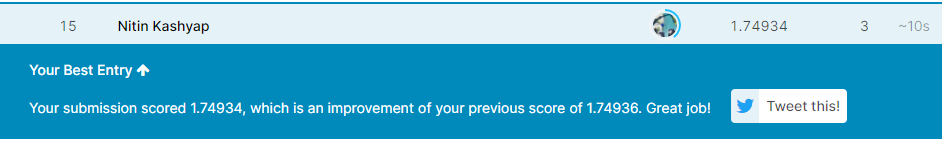

Was able to crank up the model and reduce the error again.

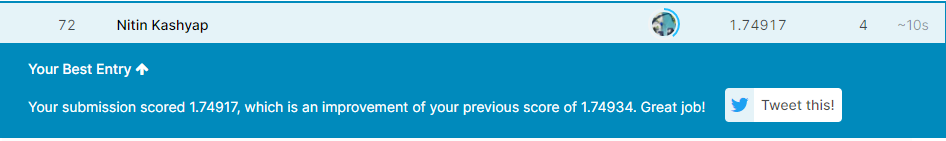

## Rerun the model and look at feature importances

I am now planning to rerun a simpler model using catboost for some iteratiosn and get a sense of the features that are most important for our model. And then rerun the optuna with the reduced number of features to get the final result

In [ ]:
from sklearn.model_selection import train_test_split

data = train_test_split(train[indep_vars], train[dep_var], test_size=0.2, random_state=0)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=indep_vars
)

validation_pool = Pool(
    data=X_validation, 
    label=y_validation, 
    cat_features=indep_vars
)


In [ ]:
model_prev = CatBoostClassifier()
model_prev.load_model("/content/Catboost_optuna_Jun21.model")

CatBoostError: ignored

In [ ]:
prev_params = model_prev.get_all_params()
model_feature = CatBoostClassifier()

model_feature.set_params(**prev_params)

In [ ]:
model_feature.fit( ,  eval_set=validation_pool)

CatBoostError: ignored

USing Loss Function Change: This methodology meaures how much the loss function cahnges based on the fetaure changes. In this porcess we are training the model with the feature and then train the modle without the feature (This second precess is approximated by using we atre removing thsi feature from all the tress and avaraging the leaf values ad then saying that this would be the effect of dropping this feature from the prediction) This loss function change works well but is time-consuming. These feature importances is both positiove and negative and I will remove the features that affect the loss function negatively.


In [ ]:
model_prev.get_feature_importance(train_pool, 'LossFunctionChange', prettified=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CatBoostError: ignored

## Using TensorFlow to develop a NN model

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, Reshape, BatchNormalization, Add,Dropout, Conv1D,AveragePooling1D,Concatenate, Average, Embedding, GlobalAveragePooling1D, Flatten, AlphaDropout

from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
#from category_encoders.cat_boost import CatBoostEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from keras.backend import int_shape

In [ ]:
train = pd.read_csv('/content/train.csv.zip')
train['target'].unique()
train['target']=train['target'].str[-1]
train.pop('id')

y = train['target']
train.pop('target')
X=train

In [ ]:
def ClassModel(input_shape):

    
    X_input = Input(input_shape)
    X = Embedding (input_dim=354, output_dim=8)(X_input)

    X = Conv1D(64,1,padding='same',activation='relu')(X)
    X = Conv1D(128,1,padding='same',activation='relu')(X)
    #X = GlobalAveragePooling1D()(X)
    X = Flatten()(X)
    #X = Dropout(0.2)(X)
    X2 = Dense(75, kernel_initializer=tf.keras.initializers.GlorotNormal(),name='lay1_a')(X)
    #X2 = BatchNormalization()(X2)
    #X2 = Dropout(0.2)(X2)
    X2 = Activation('relu')(X2)
    X3 = Dense(150, kernel_initializer=tf.keras.initializers.GlorotNormal(),name='lay1_b')(X)
    #X3 = BatchNormalization()(X3)
    #X3 = Dropout(0.2)(X3)
    X3 = Activation('relu')(X3)
    X4 = Dense(50, kernel_initializer=tf.keras.initializers.GlorotNormal(),name='lay1_c')(X)
    #X4 = BatchNormalization()(X4)
    #X4 = Dropout(0.2)(X4)
    X4 = Activation('relu')(X4)
    X = Concatenate()([X2,X3,X4])
    X = Dense(100, name='lay1',kernel_initializer='glorot_uniform')(X)
    #X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Dropout(0.2)(X)
    X = Activation('relu')(X)
#     X = Dense(300, name='lay2',kernel_initializer='glorot_uniform')(X)
#     X = BatchNormalization(axis = -1, name = 'bn2')(X)
#     X = Dropout(0.4)(X)
#     X = Activation('relu')(X)
#     X = Dense(100, name='lay3',kernel_initializer='glorot_uniform')(X)
#     X = BatchNormalization(axis = -1, name = 'bn3')(X)
#     X = Dropout(0.4)(X)
#     X = Activation('relu')(X)
    X = Dense(50, name='lay4',kernel_initializer='glorot_uniform')(X)
#     X = BatchNormalization(axis = -1, name = 'bn4')(X)
#     X = Dropout(0.4)(X)
    X = Activation('relu')(X)

    X = Dense(9, activation='softmax', name='output')(X)


    model = Model(inputs = X_input, outputs = X, name='ClassModel')

    
    return model

def ResModel(input_shape):

    
    X_input = Input(input_shape)
    X = Embedding (input_dim=354, output_dim=9)(X_input)
    X = Conv1D(16,1,activation='relu')(X)
    X = Flatten()(X)
    X2 = Dense(75, kernel_initializer=tf.keras.initializers.GlorotNormal(),name='lay1_a')(X)
    #X2 = BatchNormalization()(X2)
    #X2 = Dropout(0.2)(X2)
    X2 = Activation("relu")(X2)
    X3 = Dense(150, kernel_initializer=tf.keras.initializers.GlorotNormal(),name='lay1_b')(X)
    #X3 = BatchNormalization()(X3)
    #X3 = Dropout(0.2)(X3)
    X3 = Activation("relu")(X3)
    X4 = Dense(50, kernel_initializer=tf.keras.initializers.GlorotNormal(),name='lay1_c')(X)
    #X4 = BatchNormalization()(X4)
    #X4 = Dropout(0.2)(X4)
    X4 = Activation("relu")(X4)
    X = Concatenate()([X2,X3,X4])
#     X = Dropout(0.3)(X)
    X = Dense(120, kernel_initializer=tf.keras.initializers.GlorotNormal(),name='lay1')(X)
#     X = BatchNormalization()(X)
#     X = Dropout(0.3)(X)
    X1 = Activation("relu")(X)
    X = Dense(120, kernel_initializer=tf.keras.initializers.GlorotNormal(), name='lay2')(X1)
    
#     X = BatchNormalization()(X)
#     X = Dropout(0.3)(X)
    X = Activation("relu")(X)
    X = Dense(120, kernel_initializer=tf.keras.initializers.GlorotNormal(), name='lay3')(X)
#     X = BatchNormalization()(X)
#     X = Dropout(0.3)(X)
    X = Activation("relu")(X)
    X = Add()([X1,X])
    X = Dense(60, kernel_initializer=tf.keras.initializers.GlorotNormal(), name='lay1a')(X)
#     X = BatchNormalization()(X)
#     X = Dropout(0.3)(X)

    X2 = Activation("relu")(X)
    X = Dense(60, kernel_initializer=tf.keras.initializers.GlorotNormal(), name='lay2a')(X1)
#     X = BatchNormalization()(X)
#     X = Dropout(0.3)(X)
    X = Activation("relu")(X)
    X = Dense(60, kernel_initializer=tf.keras.initializers.GlorotNormal(), name='lay3a')(X)
#     X = BatchNormalization()(X)
#     X = Dropout(0.3)(X)
    X = Activation("relu")(X)
    X = Concatenate()([X2,X])
    X = Add()([X,X1])
    X = Dense(30, kernel_initializer=tf.keras.initializers.GlorotNormal(), name='lay1b')(X)
#     X = BatchNormalization()(X)
#     X = Dropout(0.3)(X)
    X3 = Activation("relu")(X)
    X = Dense(30, kernel_initializer=tf.keras.initializers.GlorotNormal(), name='lay2b')(X1)
#     X = BatchNormalization()(X)
#     X = Dropout(0.3)(X)
    X = Activation("relu")(X)
    X = Dense(30, kernel_initializer=tf.keras.initializers.GlorotNormal(), name='lay3b')(X)
#     X = BatchNormalization()(X)
#     X = Dropout(0.3)(X)
    X = Activation("relu")(X)
    X = Concatenate()([X3,X2,X])
    X = Add()([X,X1])
    X = Dense(20, kernel_initializer=tf.keras.initializers.GlorotNormal(), name='final')(X)
    
    X = Dense(9, activation='softmax', name='output')(X)


    model = Model(inputs = X_input, outputs = X, name='ResModel')

    
    return model


In [ ]:

def prediction (X_train, y_train, X_test):
    
    keras.backend.clear_session()

    kfold = StratifiedKFold(n_splits = 10, shuffle=True)

    y_pred = np.zeros((100000,9))
    train_oof = np.zeros((200000,9))

    for idx in kfold.split(X=X_train, y=y_train):
        train_idx, val_idx = idx[0], idx[1]
        xtrain = X_train.iloc[train_idx]
        ytrain = y_train.iloc[train_idx]
        xval = X_train.iloc[val_idx]
        yval = y_train.iloc[val_idx]
        ytrain = ytrain.astype('int')
        yval = yval.astype('int')
        ytrain-=1
        yval-=1
        ytrain = to_categorical(ytrain)
        yval = to_categorical(yval)


        
        #checkpoint_filepath = '/kaggle/working/ckpt1'
        
        #model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #            filepath=checkpoint_filepath,
        #            save_weights_only=True,
        #            monitor='val_loss',
        #            mode='min',
        #            save_best_only=True)
        
        keras.backend.clear_session()
        # fit model for current fold
        classmodel = ResModel(xtrain.shape[1:])
        classmodel.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
        
        classmodel.fit(xtrain, ytrain,
        batch_size = 128, epochs = 100,
        validation_data=(xval, yval)
        #callbacks=[model_checkpoint_callback]
        )
        keras.backend.clear_session()
        #classmodel.load_weights(checkpoint_filepath)
        #create predictions
        y_pred += classmodel.predict(X_test)/kfold.n_splits
        #print(y_pred)
               
        val_pred = classmodel.predict(xval)
        # getting out-of-fold predictions on training set
        train_oof[val_idx] = val_pred
        
        # calculate and append logloss
        fold_logloss = metrics.log_loss(yval,val_pred)
        #print(classmodel.evaluate(xval,yval))
        #classmodel.evaluate(xval,yval)
        print("Logloss: {0:0.5f}". format(fold_logloss))
    
    return y_pred, train_oof, classmodel

In [ ]:
X_test = pd.read_csv('/content/test.csv.zip')
X_test=X_test.iloc[:,1:]
main_pred, train_oof, classmodel = prediction(X, y, X_test)
sub = pd.read_csv('/content/sample_submission.csv.zip')
sub.iloc[:,1:]=main_pred
sub=sub.set_index('id')
sub.to_csv('embmodel.csv')
tf.keras.utils.plot_model(classmodel,show_shapes=True) 

Epoch 1/100
1407/1407 [==============================] - 10s 6ms/step - loss: 1.8119 - accuracy: 0.3328 - val_loss: 1.7867 - val_accuracy: 0.3453
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7939 - accuracy: 0.3428 - val_loss: 1.7794 - val_accuracy: 0.3504
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7730 - accuracy: 0.3519 - val_loss: 1.7491 - val_accuracy: 0.3620
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7570 - accuracy: 0.3596 - val_loss: 1.7472 - val_accuracy: 0.3609
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7558 - accuracy: 0.3594 - val_loss: 1.7490 - val_accuracy: 0.3513
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7545 - accuracy: 0.3589 - val_loss: 1.7472 - val_accuracy: 0.3528
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7537 - accuracy: 0.3598 - val_loss: 1.7520 - val_a

KeyboardInterrupt: ignored

In [ ]:
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f embmodel.csv -m "Embedding Model TensorFlow"

In [ ]:
classmodel.layers

## Using Wandb and TensorFlow to build and improve an Embedding NN model


In [ ]:
!pip install wandb
!wandb login

#APi KEy: b5e2b28dc352c4319dbbf0a0c8555d3f8056a259

     |████████████████████████████████| 1.8MB 8.3MB/s 
     |████████████████████████████████| 174kB 40.2MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 133kB 52.8MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=5a5312db301ddc6081f58bf758bc6892fa54552553c49b3057bc72204510ac9e
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=e6b4cbd93c00090c0b36cb853a529048b0e0c996d65405c9c8bb0e8907202177
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: A

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.layers import Input, Dense, Activation, Reshape, BatchNormalization, Add,Dropout, Conv1D,AveragePooling1D,Concatenate, Average, Embedding, GlobalAveragePooling1D, Flatten, AlphaDropout

from tensorflow.keras.models import Model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wandb
from wandb.keras import WandbCallback

wandb.login()


wandb: Currently logged in as: nitinkash (use `wandb login --relogin` to force relogin)


True

In [ ]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip') 
submission = pd.read_csv('sample_submission.csv.zip')
submission = submission.set_index('id')

train.target = pd.Categorical(train.target)
train['target'] = train.target.cat.codes

indep_vars = ['feature_' + str(i) for i in range(75)]
dep_var = ['target']

In [ ]:
train.shape, test.shape
train.pop('id')
y = train.pop('target')

In [ ]:
y

0         5
1         5
2         1
3         7
4         1
         ..
199995    5
199996    5
199997    7
199998    6
199999    7
Name: target, Length: 200000, dtype: int8

In [ ]:
emb_sizes = train.max(axis=0)

#### Building the NEural Network:

In [ ]:
!pip install tensorflow_addons


     |████████████████████████████████| 686kB 28.1MB/s 


In [ ]:

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.feature_selection import mutual_info_classif

import gc

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers

from keras.models import Model


In [ ]:
def custom_metric(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = K.mean(cce(y_true, y_pred))
    return loss

cce = tf.keras.losses.CategoricalCrossentropy()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_metric', min_delta=1e-05, patience=4, verbose=0,
    mode='min', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_custom_metric', factor=0.7, patience=2, verbose=0,
    mode='min')

In [ ]:
def conv_model1():

    conv_inputs = layers.Input(shape = (75))
    embed = layers.Embedding (input_dim = 354, 
                              output_dim = 6,
                              embeddings_regularizer='l2')(conv_inputs)
    embed = layers.Conv1D(12,1,activation = 'relu')(embed)        
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)
    
    hidden = tfa.layers.WeightNormalization(
                layers.Dense(
                units=32,
                activation ='selu',
                kernel_initializer = "lecun_normal"))(hidden)
    
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(
    layers.Dense(
                units = 32,
                activation='relu',
                kernel_initializer = "lecun_normal"))(output) 
    output = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, output]))
    output = tfa.layers.WeightNormalization(
    layers.Dense(
                units = 32, 
                activation = 'relu',
                kernel_initializer = "lecun_normal"))(output)
    
    conv_outputs = layers.Dense(
                units = 9, 
                activation ='softmax',
                kernel_initializer ="lecun_normal")(output)
    
    model = Model(conv_inputs,conv_outputs)
    
    return model

In [ ]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip') 
submission = pd.read_csv('sample_submission.csv.zip')
submission = submission.set_index('id')

targets = pd.get_dummies(train['target'])
dic = {'Class_1':1,'Class_2':2,'Class_3':3,'Class_4':4,'Class_5':5,'Class_6':6,'Class_7':7,'Class_8':8,'Class_9':9}
target_num = train["target"].map(dic)

In [ ]:
y_valids = []

oof_NN_class = np.zeros((train.shape[0],9))
pred_NN_class = np.zeros((test.shape[0],9))
pred_NN_class_all = np.zeros((test.shape[0],9))

oof_NN_a = np.zeros((train.shape[0],9))
pred_NN_a = np.zeros((test.shape[0],9))
pred_NN_a_all = np.zeros((test.shape[0],9))

oof_NN_h = np.zeros((train.shape[0],9))
pred_NN_h = np.zeros((test.shape[0],9))
pred_NN_h_all = np.zeros((test.shape[0],9))

oof_NN_v = np.zeros((train.shape[0],9))
pred_NN_v = np.zeros((test.shape[0],9))
pred_NN_v_all = np.zeros((test.shape[0],9))

NN_c_train_preds = []
NN_c_test_preds = []

NN_h_train_preds = []
NN_h_test_preds = []

NN_v_train_preds = []
NN_v_test_preds = []

NN_a_train_preds = []
NN_a_test_preds = []

N_FOLDS = 25
SEED = 42
EPOCH = 500
N_round = 2

for i in range(N_round ):
    
    
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state= SEED * i)
    
    print(f"\n =========== ROUND {i+1} ===============\n")
    
    for fold, (tr_idx, ts_idx) in enumerate(skf.split(train,train.iloc[:,-1])):
        print(f"\n--------TRAINING FOLD {fold} ---------\n")

        X_train = train.iloc[:,1:-1].iloc[tr_idx]
        y_train = targets.iloc[tr_idx]
        X_test = train.iloc[:,1:-1].iloc[ts_idx]
        y_test = targets.iloc[ts_idx]

        K.clear_session()

        #================= NN CONV MODEL training =========

        model_conv = conv_model1()

        model_conv.compile(loss='categorical_crossentropy', 
                                optimizer = keras.optimizers.Adam(learning_rate=2e-4), 
                                metrics=custom_metric)
        model_conv.fit(X_train, y_train,
                  batch_size = 256, epochs = EPOCH,
                  validation_data=(X_test, y_test),
                  callbacks=[es, plateau],
                  verbose = 0)

        #============== Convolution Model prediction ==========

        pred_a = model_conv.predict(X_test)
        pred_a1 = model_conv.predict(X_train)
        oof_NN_a[ts_idx] += pred_a 
        score_NN_a = log_loss(y_test, pred_a)
        print(f"Score Model 1: {score_NN_a}")
        pred_NN_a += model_conv.predict(test.iloc[:,1:]) / N_FOLDS
        pred_NN_a_all += model_conv.predict(test.iloc[:,1:]) / N_FOLDS / N_round


 =========== ROUND 1 ===============


--------TRAINING FOLD 0 ---------



Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f30390b17a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Score Model 1: 1.7373326778588816

--------TRAINING FOLD 1 ---------

Score Model 1: 1.7429528020713478

--------TRAINING FOLD 2 ---------

Score Model 1: 1.756215072916355

--------TRAINING FOLD 3 ---------

Score Model 1: 1.761630692366045

--------TRAINING FOLD 4 ---------



KeyboardInterrupt: ignored

In [ ]:
submission[['Class_1', 'Class_2', 'Class_3', 'Class_4','Class_5','Class_6','Class_7','Class_8','Class_9']] = pred_NN_class_all
submission.to_csv('classifier1.csv')

In [ ]:
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f classifier1.csv -m "Base simple conv tf Model"

In [ ]:
'''def EmbeddingBlock(X, emb_size):
    embed_dim = int(min(np.ceil(emb_size / 2), 50))
    X=layers.Embedding(emb_size+1, embed_dim, embeddings_regularizer='l2')(X)
    X = layers.Reshape(target_shape=(embed_dim, ))(X)
    X=layers.Flatten()(X)
    X=layers.Dense(500, kernel_initializer=tf.keras.initializers.GlorotNormal())(X)
    X=layers.BatchNormalization(axis=-1)(X)
    X=layers.Dropout(0.4)(X)
    X=layers.Activation('relu')(X)
    return X


def get_model(df):
    inputs= []
    embeddings = []
    ''
    for c in cat_cols:
        #num_unique_vals = int(df[c].nunique())
        emb_size = X.train.max(axis=0)
        embed_dim = int(min(np.ceil(num_unique_vals / 2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_vals + 1, embed_dim, name=c)(inp)
        #Apply Dropout here
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
    ''
    for i in range(75):
        inputs.append(layers.Input(1,))
    for i, emb_size in enumerate(emb_sizes):
        embeddings.append(EmbeddingBlock(inputs[i], int(emb_size)))
    x = layers.Concatenate()(embeddings)
    x = layers.Dense(200, name='lay2',  activation = 'relu', kernel_initializer=tf.keras.initializers.GlorotNormal())(x)
    x = layers.BatchNormalization(axis = -1, name = 'bn2')(x)
    x = layers.Dropout(0.5)(x)
#    x = layers.Activation('relu')(x)
    x = layers.Dense(100, name='lay3',  activation = 'relu', kernel_initializer=tf.keras.initializers.GlorotNormal())(x)
#    x = layers.BatchNormalization(axis = -1, name = 'bn3')(x)
#    x = layers.Dropout(0.5)(x)
#    x = layers.Activation('relu')(x)
    x = layers.Dense(9, activation='softmax', name='output')(x)
    model = Model(inputs=inputs, outputs=x, name='Embedding_Model')
    
    return model
    '''

In [ ]:
get_model(train).summary()

In [ ]:
model = get_model(train)
model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
y

0         5
1         5
2         1
3         7
4         1
         ..
199995    5
199996    5
199997    7
199998    6
199999    7
Name: target, Length: 200000, dtype: int8

In [ ]:
model.fit([train.loc[:,f].values for f in indep_vars], y.values, batch_size = 128, epochs = 14)

Epoch 1/14


ValueError: ignored

In [ ]:
kfold = StratifiedKFold(n_splits = 10, shuffle=True)
y_pred = np.zeros((100000,9))
train_oof = np.zeros((200000,9))

for idx in kfold.split(X=train, y=y):
    train_idx, val_idx = idx[0], idx[1]
    xtrain = train.iloc[train_idx]
    ytrain = y.iloc[train_idx]
    xval = train.iloc[val_idx]
    yval = y.iloc[val_idx]
    ytrain = ytrain.astype('int')
    yval = yval.astype('int')
    ytrain-=1
    yval-=1

    model = get_model(train)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

    model.fit([xtrain.loc[:,f].values for f in indep_vars], pd.to_numeric(ytrain), batch_size = 128, epochs = 20)
    y_pred += classmodel.predict(X_test)/kfold.n_splits

    val_pred = classmodel.predict(xval)
    # getting out-of-fold predictions on training set
    train_oof[val_idx] = val_pred
    
    # calculate and append logloss
    fold_logloss = metrics.log_loss(yval,val_pred)
    #print(classmodel.evaluate(xval,yval))
    #classmodel.evaluate(xval,yval)
    print("Logloss: {0:0.5f}". format(fold_logloss))

Epoch 1/14
1547/1547 [==============================] - 150s 81ms/step - loss: nan - accuracy: 0.1221
Epoch 2/14
1547/1547 [==============================] - 122s 79ms/step - loss: nan - accuracy: 0.1222
Epoch 3/14
1547/1547 [==============================] - 120s 78ms/step - loss: nan - accuracy: 0.1222
Epoch 4/14
1547/1547 [==============================] - 118s 77ms/step - loss: nan - accuracy: 0.1222
Epoch 5/14
1506/1547 [============================>.] - ETA: 3s - loss: nan - accuracy: 0.1223

KeyboardInterrupt: ignored

In [ ]:
main_pred.shape

(100000, 200)

In [ ]:
sub.shape

(100000, 10)

In [ ]:
sub = pd.read_csv('sample_submission.csv.zip')
sub.iloc[:,1:]=main_pred
sub=sub.set_index('id')
sub.to_csv('my_tfModel.csv')

ValueError: ignored

In [ ]:
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f my_tfModel.csv -m "Base simple TF Model"

### Using Fast ai


In [ ]:
!pip install --upgrade fastai

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.4)


In [ ]:
import numpy as np 
import pandas as pd 
import fastai
from fastai.tabular.all import *



In [ ]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip') 
sample_submission = pd.read_csv('sample_submission.csv.zip')

train.target = pd.Categorical(train.target)
train['target'] = train.target.cat.codes

indep_vars = ['feature_' + str(i) for i in range(75)]
dep_var = ['target']

In [ ]:
import wandb
from fastai.callback.wandb import WandbCallback

wandb.init(project='tpcJun', entity='nitinkash')  

n=10
pred = sample_submission[sample_submission.columns[1:]]*0
log = pd.DataFrame(columns=['Loss Train','Loss Validation','Accuracy'])

for i in range(n):
    splits = RandomSplitter(valid_pct=0.3)(range_of(train))
    
    to = TabularPandas(
        train,
        y_names="target",
        y_block = CategoryBlock,
        cat_names = indep_vars,
        procs = [Categorify],
        splits=splits)
    
    loaders = to.dataloaders(bs=256)
    learn = tabular_learner(loaders, metrics=accuracy,layers=[400,200,100])
    learn.fine_tune(5, cbs=WandbCallback())
    loss = learn.recorder.log[1:4]
    log.loc[len(log)] = loss
    dl = learn.dls.test_dl(test[indep_vars])
    pred+= learn.get_preds(dl=dl)[0].numpy()/n

log.describe()

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.760212,1.763360,0.358483,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.751347,1.761349,0.357117,00:14
1,1.751319,1.754586,0.360867,00:16
2,1.732643,1.758830,0.360000,00:16
3,1.694515,1.786344,0.354183,00:15
4,1.632646,1.826944,0.347283,00:15


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.767195,1.770747,0.351250,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.746005,1.760289,0.357833,00:14
1,1.740296,1.759351,0.357367,00:15
2,1.733669,1.760480,0.359217,00:16
3,1.691971,1.792537,0.351633,00:15
4,1.627157,1.830427,0.344667,00:15


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.757772,1.767650,0.357517,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.746079,1.754012,0.359433,00:14
1,1.756429,1.757512,0.357617,00:15
2,1.730067,1.760968,0.357800,00:15
3,1.676232,1.795751,0.349383,00:15
4,1.613920,1.844784,0.340417,00:16


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.769339,1.755938,0.359383,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.747505,1.755559,0.359250,00:14
1,1.741776,1.751421,0.360250,00:15
2,1.738125,1.757160,0.359367,00:15
3,1.683477,1.788251,0.353333,00:15
4,1.626947,1.823900,0.345967,00:15


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.766214,1.757098,0.360483,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.740282,1.754356,0.360617,00:14
1,1.746247,1.752255,0.359300,00:15
2,1.736547,1.754223,0.358200,00:15
3,1.686455,1.789755,0.351750,00:15
4,1.614124,1.845294,0.342300,00:15


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.768590,1.761582,0.353517,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.751888,1.757103,0.360533,00:14
1,1.742130,1.756774,0.358917,00:15
2,1.730845,1.757504,0.359267,00:15
3,1.690707,1.786458,0.350267,00:15
4,1.639708,1.824516,0.341183,00:17


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.763231,1.760707,0.358200,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.751050,1.756307,0.357717,00:14
1,1.749340,1.752529,0.360467,00:15
2,1.734925,1.755805,0.356433,00:14
3,1.692954,1.784191,0.352450,00:15
4,1.641886,1.820158,0.344900,00:15


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.755902,1.769750,0.347917,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.750517,1.753261,0.355550,00:14
1,1.739976,1.756716,0.356567,00:15
2,1.724806,1.761603,0.355033,00:15
3,1.687991,1.794379,0.349167,00:15
4,1.616076,1.835337,0.341417,00:15


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.774278,1.761793,0.354733,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.746634,1.754074,0.358083,00:14
1,1.748075,1.754374,0.355183,00:15
2,1.739434,1.756819,0.359917,00:15
3,1.687033,1.785866,0.351767,00:15
4,1.627529,1.829849,0.343417,00:15


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.761038,1.762059,0.358317,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.755838,1.753854,0.354683,00:14
1,1.758328,1.754847,0.360933,00:15
2,1.737863,1.754674,0.359883,00:15
3,1.703351,1.777514,0.353233,00:15
4,1.645787,1.819137,0.344767,00:15


,Loss Train,Loss Validation,Accuracy
count,10.000000,10.000000,10.000000
mean,1.628578,1.830035,0.343632
std,0.011545,0.009265,0.002256
min,1.613920,1.819137,0.340417
25%,1.618794,1.824054,0.341637
50%,1.627343,1.828396,0.344042
75%,1.637943,1.834109,0.344867
max,1.645787,1.845294,0.347283


In [ ]:
sample_submission[sample_submission.columns[1:]] = pred
sample_submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f submission.csv -m "Base fastai Model2"

100% 17.9M/17.9M [00:00<00:00, 36.4MB/s]
Successfully submitted to Tabular Playground Series - Jun 2021